<a href="https://colab.research.google.com/github/sker12/hol/blob/main/Yeison_DuqueInforme_de_Gerencia_SP500.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Informe de Gerencia – S&P 500
**Análisis con datos locales (sp500_companies, sp500_index, sp500_stocks)**

**Autor:** (Yeison Duque Diaz)  
**Fecha de ejecución:** (se autogenera en la siguiente celda)  
**Versión del cuaderno:** v1.0

---
**Nota:** Este cuaderno está diseñado para ejecutarse sin internet y sin depender de APIs.
Si las tablas `sp500_companies`, `sp500_index` y `sp500_stocks` no existen en memoria, se crean **mocks**
con columnas mínimas para garantizar la ejecución.

In [2]:
# =============================================================================
# 0. Portada dinámica (autogenera fecha) y utilidades básicas
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, timezone, UTC
from IPython.display import Markdown, display

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 200)
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["axes.grid"] = True

np.random.seed(7)

now_utc = datetime.now(UTC)
fecha_bogota = now_utc.astimezone(timezone(timedelta(hours=-5)))

display(Markdown(f"""
**Autor:** Analista Financiero Yeison Duque Diaz
**Fecha de ejecución:** {fecha_bogota.strftime('%Y-%m-%d %H:%M:%S')} (America/Bogota)
**Versión del cuaderno:** v1.0
"""))

QUALITY_NOTES = []


**Autor:** Analista Financiero Yeison Duque Diaz
**Fecha de ejecución:** 2025-10-17 14:34:00 (America/Bogota)
**Versión del cuaderno:** v1.0


# 0. Email del Jefe (copia del correo)
A continuación se simula el correo recibido con las peticiones de Dirección General.

In [3]:
# =============================================================================
# Email simulado del "Jefe" con fecha dinámica
# =============================================================================

correo = f"""
**Asunto:** Solicitud de informe S&P 500 – Dirección General
**De:** Dirección General <ceo@datosup.com>
**Para:** Analista Financiero <tu@datosup.com>
**Fecha:** {fecha_bogota.strftime('%Y-%m-%d %H:%M:%S')} (America/Bogota)

**Cuerpo:**

Hola Equipo requiero solicitar estos indicadores y riesgo del SP500 para poder
llevar el informe a erencia, su apoyo es muy valioso gracias.
Se requiere los siguientes puntos:
1) Panorama general del índice S&P 500 en el período analizado.
2) Desempeño por sector e identificación de líderes/rezagados.
3) Principales métricas de mercado: capitalización, liquidez, volatilidad.
4) Top 10 compañías por peso y por capitalización.
5) Evolución temporal: retornos diarios, semanales y mensuales.
6) Riesgo: volatilidad, drawdown, correlaciones.
7) Comparar desempeño de sectores clave (Tecnología, Salud, Finanzas, etc.).
8) Señalar outliers, datos faltantes y calidad de la base.
9) Conclusiones ejecutivas y próximos pasos recomendados.
"""
display(Markdown(correo))


**Asunto:** Solicitud de informe S&P 500 – Dirección General
**De:** Dirección General <ceo@datosup.com>
**Para:** Analista Financiero <tu@datosup.com>
**Fecha:** 2025-10-17 14:34:00 (America/Bogota)

**Cuerpo:**

Hola Equipo requiero solicitar estos indicadores y riesgo del SP500 para poder
llevar el informe a erencia, su apoyo es muy valioso gracias.
Se requiere los siguientes puntos:
1) Panorama general del índice S&P 500 en el período analizado.
2) Desempeño por sector e identificación de líderes/rezagados.
3) Principales métricas de mercado: capitalización, liquidez, volatilidad.
4) Top 10 compañías por peso y por capitalización.
5) Evolución temporal: retornos diarios, semanales y mensuales.
6) Riesgo: volatilidad, drawdown, correlaciones.
7) Comparar desempeño de sectores clave (Tecnología, Salud, Finanzas, etc.).
8) Señalar outliers, datos faltantes y calidad de la base.
9) Conclusiones ejecutivas y próximos pasos recomendados.


# 1. Configuración y dependencias
**Objetivo:** Definir parámetros editables y cargar dependencias estándar.

- **FECHA_INICIO**, **FECHA_FIN**: rango temporal del análisis.
- **SECTOR_FOCUS**: sector a analizar en profundidad (o "Todos").
- **SYMBOLS_FOCUS**: lista de símbolos de interés (puede estar vacía).
- **VENTANAS_MOVILES**: ventanas para medias móviles / volatilidades.
- **USE_PLOTLY**: intenta usar plotly si está disponible localmente (sin instalar).

In [4]:
# =============================================================================
# 1. Parámetros editables por el usuario
# =============================================================================

FECHA_INICIO = None
FECHA_FIN    = None
SECTOR_FOCUS   = "Todos"
SYMBOLS_FOCUS  = []
VENTANAS_MOVILES = [20, 50, 200]
USE_PLOTLY = True

plotly_ok = False
if USE_PLOTLY:
    try:
        import plotly.graph_objects as go
        import plotly.express as px
        plotly_ok = True
    except Exception as _:
        plotly_ok = False
        QUALITY_NOTES.append("Plotly no disponible localmente: se continuará con Matplotlib sin interactividad.")

# 2. Carga de datos (Google Drive con fallback a mocks)
**Regla:** Usar exclusivamente DataFrames locales desde tus CSV de Drive.
Si ocurre un error de lectura, se crean **DataFrames de ejemplo mínimos** para que el cuaderno siempre corra.

In [5]:
# =============================================================================
# 2. Carga de datos DESDE GOOGLE DRIVE (con fallback a mocks)
# =============================================================================

import os
from google.colab import drive

try:
    drive.mount('/content/drive', force_remount=False)
except Exception as _:
    pass

PATHS = {
    'stocks': '/content/drive/MyDrive/BOOTCAMP/sp500_stocks.csv',
    'companies': '/content/drive/MyDrive/BOOTCAMP/sp500_companies.csv',
    'index': '/content/drive/MyDrive/BOOTCAMP/sp500_index.csv',
    'export_dir': '/content/'
}

def leer_csv_seguro(path, parse_dates=None, dtype=None):
    """
    Lee un CSV verificando existencia y aplica parseo de fechas/dtypes.
    - parse_dates: lista con nombres de columnas a convertir a datetime
    - dtype: diccionario {columna: tipo} para forzar tipos (cuando aplique)
    """
    if not os.path.exists(path):
        raise FileNotFoundError(f"No existe el archivo: {path}")
    df = pd.read_csv(path, parse_dates=parse_dates, dtype=dtype)
    return df

def asegurar_columnas(df, cols):
    faltantes = [c for c in cols if c not in df.columns]
    for c in faltantes:
        df[c] = np.nan
    return faltantes

try:
    dtypes_companies = {
        "Exchange": "string", "Symbol": "string", "Shortname": "string", "Longname": "string",
        "Sector": "string", "Industry": "string", "Currentprice": "float64",
        "Marketcap": "float64", "Ebitda": "float64", "Revenuegrowth": "float64",
        "City": "string", "State": "string", "Country": "string",
        "Fulltimeemployees": "float64",
        "Longbusinesssummary": "string", "Weight": "float64"
    }

    companies = leer_csv_seguro(
        PATHS['companies'],
        parse_dates=None,
        dtype=dtypes_companies
    )

    index_df = leer_csv_seguro(
        PATHS['index'],
        parse_dates=['Date'],
        dtype={"S&P500": "float64"}
    )

    stocks = leer_csv_seguro(
        PATHS['stocks'],
        parse_dates=['Date'],
        dtype={
            "Symbol": "string",
            "Adj Close": "float64", "Close": "float64",
            "High": "float64", "Low": "float64", "Open": "float64",
            "Volume": "float64"
        }
    )

    QUALITY_NOTES.append("Datos cargados desde Google Drive (CSV locales).")
except Exception as e:
    QUALITY_NOTES.append(f"⚠️ Falló la lectura desde Drive: {e}. Se cargan datos de ejemplo (mocks) para continuar.")
    try:
        sp500_companies, sp500_index, sp500_stocks = crear_mocks()
        companies, index_df, stocks = sp500_companies.copy(), sp500_index.copy(), sp500_stocks.copy()
    except NameError:
        def crear_mocks_min():
            fechas = pd.date_range("2024-01-02", periods=60, freq="B")
            idx = pd.DataFrame({"Date": fechas, "S&P500": np.cumprod(1+np.random.normal(0.0005,0.01,len(fechas)))*4700})
            comp = pd.DataFrame({
                "Exchange":["NYSE","NASDAQ","NASDAQ"],
                "Symbol":["AAA","BBB","CCC"], "Shortname":["AAA","BBB","CCC"],
                "Longname":["AAA Corp","BBB Inc","CCC Ltd"],
                "Sector":["Information Technology","Health Care","Financials"],
                "Industry":["Software","Biotech","Banks"],
                "Currentprice":[100,50,30], "Marketcap":[5e11,2e11,1e11],
                "Ebitda":[1e10,5e9,3e9], "Revenuegrowth":[0.1,0.05,0.02],
                "City":["NY","SF","CHI"], "State":["NY","CA","IL"], "Country":["USA","USA","USA"],
                "Fulltimeemployees":[50000,20000,15000],
                "Longbusinesssummary":[
                    "Compañía tecnológica enfocada en software empresarial.",
                    "Biotecnológica con pipeline en fase clínica.",
                    "Banco regional con enfoque en banca de consumo."
                ],
                "Weight":[0.06,0.03,0.02]
            })
            stocks_list=[]
            for sym, base in zip(["AAA","BBB","CCC"], [100,50,30]):
                precios=np.cumprod(1+np.random.normal(0.0008,0.02,len(fechas)))*base
                df_sym=pd.DataFrame({
                    "Date":fechas,"Symbol":sym,
                    "Adj Close":precios,"Close":precios,
                    "High":precios*(1+np.random.uniform(0,0.02,len(fechas))),
                    "Low":precios*(1-np.random.uniform(0,0.02,len(fechas))),
                    "Open":precios*(1+np.random.uniform(-0.01,0.01,len(fechas))),
                    "Volume":np.random.randint(1e6,5e6,len(fechas))
                })
                stocks_list.append(df_sym)
            stk=pd.concat(stocks_list, ignore_index=True)
            return comp, idx, stk
        companies, index_df, stocks = crear_mocks_min()

cols_comp = ["Exchange","Symbol","Shortname","Longname","Sector","Industry","Currentprice",
             "Marketcap","Ebitda","Revenuegrowth","City","State","Country","Fulltimeemployees",
             "Longbusinesssummary","Weight"]
cols_index = ["Date","S&P500"]
cols_stocks = ["Date","Symbol","Adj Close","Close","High","Low","Open","Volume"]

falt_comp = asegurar_columnas(companies, cols_comp)
falt_idx  = asegurar_columnas(index_df, cols_index)
falt_stk  = asegurar_columnas(stocks, cols_stocks)
if any([falt_comp, falt_idx, falt_stk]):
    QUALITY_NOTES.append(f"Se detectaron columnas faltantes y se completaron con NaN: comp={falt_comp}, idx={falt_idx}, stk={falt_stk}")

if "Date" in index_df.columns:
    index_df["Date"] = pd.to_datetime(index_df["Date"], errors="coerce")
if "Date" in stocks.columns:
    stocks["Date"] = pd.to_datetime(stocks["Date"], errors="coerce")
if "Symbol" in companies.columns:
    companies["Symbol"] = companies["Symbol"].astype(str)
if "Symbol" in stocks.columns:
    stocks["Symbol"] = stocks["Symbol"].astype(str)

min_date_all = max(index_df["Date"].min(), stocks["Date"].min())
max_date_all = min(index_df["Date"].max(), stocks["Date"].max())

if FECHA_INICIO is None:
    FECHA_INICIO = pd.to_datetime(min_date_all)
else:
    FECHA_INICIO = pd.to_datetime(FECHA_INICIO)
if FECHA_FIN is None:
    FECHA_FIN = pd.to_datetime(max_date_all)
else:
    FECHA_FIN = pd.to_datetime(FECHA_FIN)
if FECHA_INICIO > FECHA_FIN:
    FECHA_INICIO, FECHA_FIN = FECHA_FIN, FECHA_INICIO
    QUALITY_NOTES.append("FECHA_INICIO > FECHA_FIN: se intercambiaron automáticamente para un rango válido.")

index_df = index_df.loc[(index_df["Date"]>=FECHA_INICIO) & (index_df["Date"]<=FECHA_FIN)].sort_values("Date").reset_index(drop=True)
stocks   = stocks.loc[(stocks["Date"]>=FECHA_INICIO) & (stocks["Date"]<=FECHA_FIN)].sort_values(["Symbol","Date"]).reset_index(drop=True)

if SECTOR_FOCUS and SECTOR_FOCUS != "Todos":
    syms_sector = companies.loc[companies["Sector"]==SECTOR_FOCUS, "Symbol"].unique().tolist()
    if len(syms_sector)==0:
        QUALITY_NOTES.append(f"No se encontraron símbolos para el sector '{SECTOR_FOCUS}'. Se ignora el filtro de sector.")
    else:
        companies = companies[companies["Symbol"].isin(syms_sector)].reset_index(drop=True)
        stocks    = stocks[stocks["Symbol"].isin(syms_sector)].reset_index(drop=True)

if len(SYMBOLS_FOCUS)>0:
    syms_focus = [s for s in SYMBOLS_FOCUS if s in companies["Symbol"].unique().tolist()]
    if len(syms_focus)==0:
        QUALITY_NOTES.append("SYMBOLS_FOCUS no coincide con símbolos existentes; se ignora el filtro.")
    else:
        companies = companies[companies["Symbol"].isin(syms_focus)].reset_index(drop=True)
        stocks    = stocks[stocks["Symbol"].isin(syms_focus)].reset_index(drop=True)

from IPython.display import Markdown
display(Markdown(f"**Fuente:** Google Drive (CSV)"))
display(Markdown(f"**Rango aplicado:** {FECHA_INICIO.date()} → {FECHA_FIN.date()}"))
display(Markdown(f"**Símbolos en análisis:** {int(stocks['Symbol'].nunique())}"))

**Fuente:** Google Drive (CSV)

**Rango aplicado:** 2024-01-02 → 2024-03-25

**Símbolos en análisis:** 3

# 3. Auditoría de calidad de datos
- Duplicados por clave `[Date, Symbol]` en `sp500_stocks`.
- Nulos por columna y tratamiento sugerido.
- Outliers en retornos diarios por símbolo (IQR).
- Coherencia `Adj Close` vs `Close`; volúmenes cero.

In [6]:
# =============================================================================
# 3. Auditoría de calidad de datos
# =============================================================================

dups = stocks.duplicated(subset=["Date","Symbol"]).sum()
if dups > 0:
    QUALITY_NOTES.append(f"Se encontraron {dups} duplicados en [Date, Symbol] y se eliminaron.")
    stocks = stocks.drop_duplicates(subset=["Date","Symbol"]).copy()

def resumen_nulos(df, nombre):
    nulos_abs = df.isna().sum()
    nulos_pct = df.isna().mean()*100
    res = pd.DataFrame({"nulos_abs": nulos_abs, "nulos_pct": nulos_pct.round(2)})
    display(Markdown(f"**Nulos en `{nombre}`**"))
    display(res.sort_values("nulos_pct", ascending=False))

resumen_nulos(companies, "sp500_companies")
resumen_nulos(index_df, "sp500_index")
resumen_nulos(stocks,   "sp500_stocks")

if {"Adj Close","Close"}.issubset(stocks.columns):
    diff_rel = np.abs(stocks["Adj Close"] - stocks["Close"]) / stocks["Close"]
    diff_mean = diff_rel.dropna().mean()
    display(Markdown(f"**Diferencia relativa media `Adj Close` vs `Close`:** {diff_mean:.4f}"))
    if diff_mean > 0.02:
        QUALITY_NOTES.append("Diferencia significativa entre `Adj Close` y `Close` (>2% en promedio). Revisar ajustes corporativos o fuente de datos.")

if "Volume" in stocks.columns:
    zeros_vol = (stocks["Volume"] == 0).sum()
    if zeros_vol > 0:
        QUALITY_NOTES.append(f"Se encontraron {zeros_vol} registros con `Volume`=0. Podrían ser feriados/errores de carga.")

stocks = stocks.sort_values(["Symbol","Date"]).copy()
stocks["ret_d"] = stocks.groupby("Symbol")["Adj Close"].pct_change(fill_method=None)

def detectar_outliers_iqr(x):
    q1, q3 = x.quantile(0.25), x.quantile(0.75)
    iqr = q3 - q1
    low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
    return (x < low) | (x > high)

out_flags = stocks.groupby("Symbol")["ret_d"].apply(detectar_outliers_iqr).reset_index(level=0, drop=True)
n_out = out_flags.sum()
display(Markdown(f"**Outliers en retornos diarios (IQR):** {n_out}"))
if n_out > 0:
    QUALITY_NOTES.append(f"Detectados {n_out} outliers en retornos diarios usando IQR. Se recomienda revisión puntual o winsorización si corresponde.")

**Nulos en `sp500_companies`**

,nulos_abs,nulos_pct
Exchange,0,0.0
Symbol,0,0.0
Shortname,0,0.0
Longname,0,0.0
Sector,0,0.0
Industry,0,0.0
Currentprice,0,0.0
Marketcap,0,0.0
Ebitda,0,0.0
Revenuegrowth,0,0.0


**Nulos en `sp500_index`**

,nulos_abs,nulos_pct
Date,0,0.0
S&P500,0,0.0


**Nulos en `sp500_stocks`**

,nulos_abs,nulos_pct
Date,0,0.0
Symbol,0,0.0
Adj Close,0,0.0
Close,0,0.0
High,0,0.0
Low,0,0.0
Open,0,0.0
Volume,0,0.0


**Diferencia relativa media `Adj Close` vs `Close`:** 0.0000

**Outliers en retornos diarios (IQR):** 1

# 4. Preparación de series y features
- `ret_d`: % diario por símbolo.  
- Retornos semanales y mensuales.  
- Volatilidades y medias móviles.  
- Serie agregada por **Sector**.

In [7]:
# =============================================================================
# 4. Preparación de series y features
# =============================================================================

def calc_drawdown(curva_equity):
    running_max = curva_equity.cummax()
    dd = (curva_equity / running_max) - 1
    max_dd = dd.min()
    fecha_max = dd.idxmin()
    return dd, float(max_dd), fecha_max

def rolling_std(x, w):
    return x.rolling(w, min_periods=max(2, w//2)).std()

def sma(x, w):
    return x.rolling(w, min_periods=max(2, w//2)).mean()

stocks["ret_d"] = stocks["ret_d"].fillna(0.0)
stocks["equity"] = 1 + stocks["ret_d"]
stocks["equity"] = stocks.groupby("Symbol")["equity"].cumprod()

pivot_adj = stocks.pivot(index="Date", columns="Symbol", values="Adj Close").sort_index()

weekly_last = pivot_adj.resample("W-FRI").last()
weekly_ret  = weekly_last.pct_change(fill_method=None)

monthly_last = pivot_adj.resample("ME").last()
monthly_ret  = monthly_last.pct_change(fill_method=None)

for w in VENTANAS_MOVILES:
    stocks[f"sma_{w}"] = stocks.groupby("Symbol")["Adj Close"].transform(lambda s: sma(s, w))
    stocks[f"vol_{w}"] = stocks.groupby("Symbol")["ret_d"].transform(lambda s: rolling_std(s, w))

sym_sector = companies.set_index("Symbol")["Sector"].to_dict()
stocks["Sector"] = stocks["Symbol"].map(sym_sector)
sector_price = stocks.groupby(["Date","Sector"])["Adj Close"].mean().reset_index(name="Sector_Price")

# 5. Panorama del índice S&P 500 (sp500_index)
- Serie temporal del índice.  
- Retorno acumulado, volatilidad anualizada y máximo drawdown.  
- Calendario de retornos mensuales.

### Indicadores clave del índice

,Retorno acumulado período,Volatilidad anualizada,Máximo drawdown,Fecha max DD
0,-1.49%,16.51%,-7.43%,2024-02-21


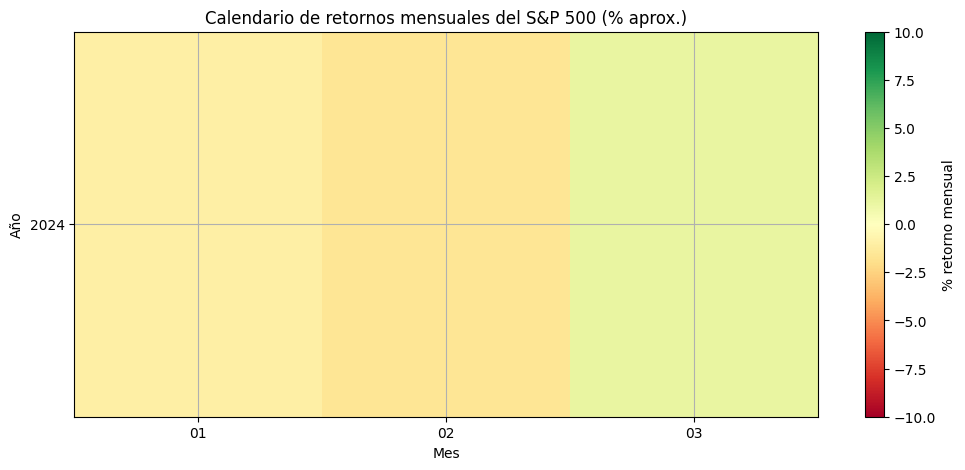

In [8]:
# =============================================================================
# 5. Índice S&P 500: métricas y gráficos
# =============================================================================

index_df = index_df.sort_values("Date").copy()
index_df["ret"] = index_df["S&P500"].pct_change().fillna(0.0)
index_df["equity"] = (1 + index_df["ret"]).cumprod()

ret_acum = index_df["equity"].iloc[-1] - 1.0
vol_anual = index_df["ret"].std() * np.sqrt(252)

dd_series, max_dd, fecha_maxdd = calc_drawdown(index_df.set_index("Date")["equity"])

met = pd.DataFrame({
    "Retorno acumulado período": [f"{ret_acum:.2%}"],
    "Volatilidad anualizada":    [f"{vol_anual:.2%}"],
    "Máximo drawdown":           [f"{max_dd:.2%}"],
    "Fecha max DD":              [str(fecha_maxdd.date()) if pd.notna(fecha_maxdd) else "N/A"]
})
display(Markdown("### Indicadores clave del índice"))
display(met)

if plotly_ok:
    fig = px.line(index_df, x="Date", y="S&P500", title="S&P 500 – Serie temporal")
    fig.show()
else:
    plt.figure()
    plt.plot(index_df["Date"], index_df["S&P500"])
    plt.title("S&P 500 – Serie temporal")
    plt.xlabel("Fecha"); plt.ylabel("Nivel índice")
    plt.show()

tmp = index_df.copy()
tmp["Year"] = tmp["Date"].dt.year
tmp["Month"] = tmp["Date"].dt.month
monthly = tmp.groupby(["Year","Month"])["ret"].apply(lambda s: (1+s).prod()-1).unstack(fill_value=0.0)

plt.figure(figsize=(12, 5))
plt.imshow(monthly.values*100, aspect="auto", cmap="RdYlGn", vmin=-10, vmax=10)
plt.colorbar(label="% retorno mensual")
plt.xticks(ticks=np.arange(monthly.shape[1]), labels=[f"{m:02d}" for m in monthly.columns])
plt.yticks(ticks=np.arange(monthly.shape[0]), labels=monthly.index)
plt.title("Calendario de retornos mensuales del S&P 500 (% aprox.)")
plt.xlabel("Mes"); plt.ylabel("Año")
plt.show()

# 6. Desempeño por sector
- Ranking por retorno acumulado, volatilidad anualizada y ratio retorno/volatilidad.  
- Tabla y gráfico de barras.

In [9]:
# =============================================================================
# 6. Desempeño por sector: ranking y gráfico
# =============================================================================

ret_sector = stocks.groupby(["Date","Sector"])["ret_d"].mean().reset_index()

sector_kpi = ret_sector.groupby("Sector").agg(
    ret_acum = ("ret_d", lambda s: (1+s).prod()-1),
    vol      = ("ret_d", lambda s: s.std()*np.sqrt(252))
).reset_index()
sector_kpi["ratio_ret_vol"] = np.where(sector_kpi["vol"]>0, sector_kpi["ret_acum"]/sector_kpi["vol"], np.nan)

display(Markdown("### Ranking sectorial (ratio retorno/volatilidad)"))
display(sector_kpi.sort_values("ratio_ret_vol", ascending=False).reset_index(drop=True))

orden = sector_kpi.sort_values("ret_acum", ascending=False)
if plotly_ok:
    fig = px.bar(orden, x="Sector", y="ret_acum", title="Retorno acumulado por sector", text=orden["ret_acum"].map(lambda x: f"{x:.1%}"))
    fig.update_traces(textposition="outside")
    fig.show()
else:
    plt.figure()
    plt.bar(orden["Sector"], orden["ret_acum"])
    plt.xticks(rotation=45, ha="right")
    plt.title("Retorno acumulado por sector")
    plt.ylabel("Retorno acumulado")
    plt.show()

### Ranking sectorial (ratio retorno/volatilidad)

,Sector,ret_acum,vol,ratio_ret_vol
0,Information Technology,0.181664,0.297182,0.611289
1,Financials,0.124887,0.331932,0.376242
2,Health Care,-0.119917,0.331224,-0.362042


# 7. Líderes y rezagados (compañías)
- Top 10 por Marketcap y por Weight (si existe).  
- Top/Bottom 10 por retorno total del período.  
- Tablas y barras horizontales.

### Top 10 por Marketcap

,Symbol,Shortname,Sector,Marketcap,Retorno_total,Volumen_prom
0,AAA,AAA,Information Technology,5.000000e+11,0.181664,3.145056e+06
1,BBB,BBB,Health Care,2.000000e+11,-0.119917,3.142640e+06
2,CCC,CCC,Financials,1.000000e+11,0.124887,2.770293e+06


### Top 10 por Weight

,Symbol,Shortname,Sector,Weight,Marketcap,Retorno_total
0,AAA,AAA,Information Technology,0.06,5.000000e+11,0.181664
1,BBB,BBB,Health Care,0.03,2.000000e+11,-0.119917
2,CCC,CCC,Financials,0.02,1.000000e+11,0.124887


### Top 10 Ganadores por Retorno

,Symbol,Shortname,Sector,Retorno_total,Marketcap
0,AAA,AAA,Information Technology,0.181664,5.000000e+11
2,CCC,CCC,Financials,0.124887,1.000000e+11
1,BBB,BBB,Health Care,-0.119917,2.000000e+11


### Bottom 10 por Retorno

,Symbol,Shortname,Sector,Retorno_total,Marketcap
1,BBB,BBB,Health Care,-0.119917,2.000000e+11
2,CCC,CCC,Financials,0.124887,1.000000e+11
0,AAA,AAA,Information Technology,0.181664,5.000000e+11


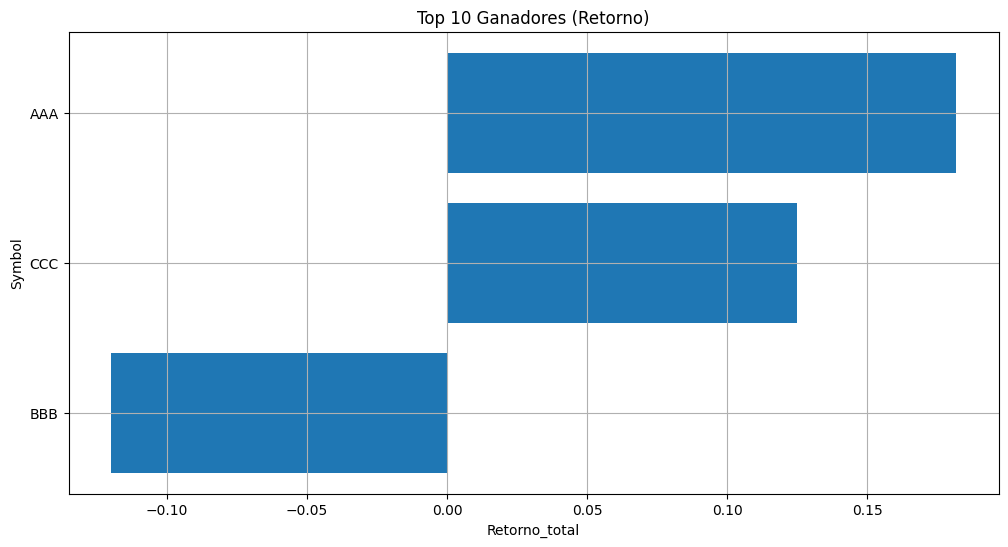

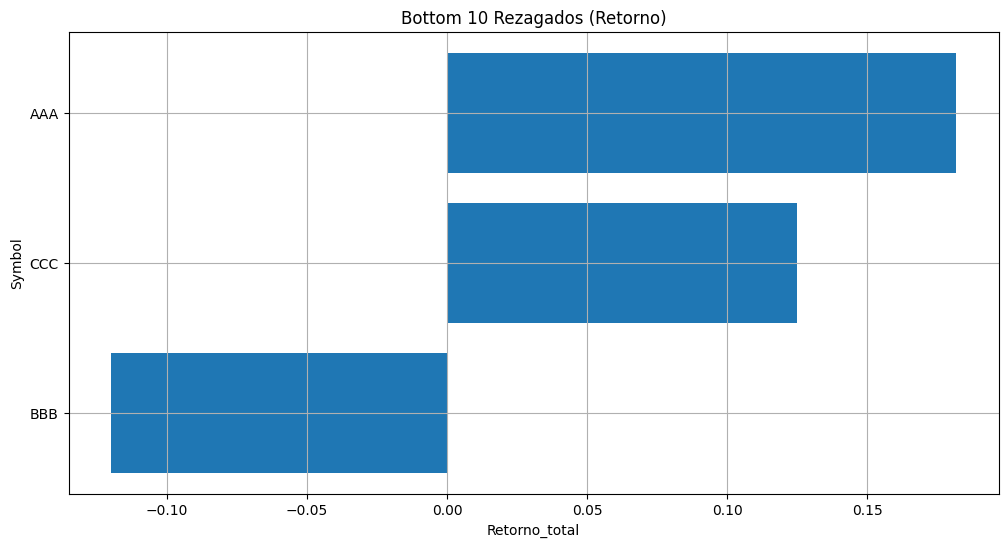

In [10]:
# =============================================================================
# 7. Líderes y rezagados
# =============================================================================

tab_mc = companies[["Symbol","Shortname","Longname","Sector","Marketcap","Weight"]].copy()

sym_first = stocks.groupby("Symbol")["Adj Close"].first()
sym_last  = stocks.groupby("Symbol")["Adj Close"].last()
ret_total = (sym_last / sym_first) - 1.0
vol_prom  = stocks.groupby("Symbol")["Volume"].mean()

tabla_perf = pd.DataFrame({
    "Symbol": ret_total.index,
    "Retorno_total": ret_total.values,
    "Volumen_prom":  vol_prom.reindex(ret_total.index).values
}).merge(tab_mc, on="Symbol", how="left")

top_mc = tabla_perf.sort_values("Marketcap", ascending=False).head(10)

if tabla_perf["Weight"].notna().any():
    top_w = tabla_perf.dropna(subset=["Weight"]).sort_values("Weight", ascending=False).head(10)
else:
    top_w = pd.DataFrame()
    QUALITY_NOTES.append("No se cuenta con `Weight` para todas las compañías; no se muestra ranking por peso.")

top_ret = tabla_perf.sort_values("Retorno_total", ascending=False).head(10)
bot_ret = tabla_perf.sort_values("Retorno_total", ascending=True).head(10)

display(Markdown("### Top 10 por Marketcap"))
display(top_mc[["Symbol","Shortname","Sector","Marketcap","Retorno_total","Volumen_prom"]])

if not top_w.empty:
    display(Markdown("### Top 10 por Weight"))
    display(top_w[["Symbol","Shortname","Sector","Weight","Marketcap","Retorno_total"]])

display(Markdown("### Top 10 Ganadores por Retorno"))
display(top_ret[["Symbol","Shortname","Sector","Retorno_total","Marketcap"]])

display(Markdown("### Bottom 10 por Retorno"))
display(bot_ret[["Symbol","Shortname","Sector","Retorno_total","Marketcap"]])

def barras_horiz(df, titulo, col="Retorno_total"):
    dfp = df.copy().sort_values(col)
    plt.figure()
    plt.barh(dfp["Symbol"], dfp[col])
    plt.title(titulo)
    plt.xlabel(col)
    plt.ylabel("Symbol")
    plt.show()

barras_horiz(top_ret,  "Top 10 Ganadores (Retorno)")
barras_horiz(bot_ret,  "Bottom 10 Rezagados (Retorno)")

# 8. Liquidez y volatilidad
- Histograma de volumen promedio.  
- Volatilidad diaria por símbolo y boxplot por sector.  
- Matriz de correlaciones (top por capitalización + índice).

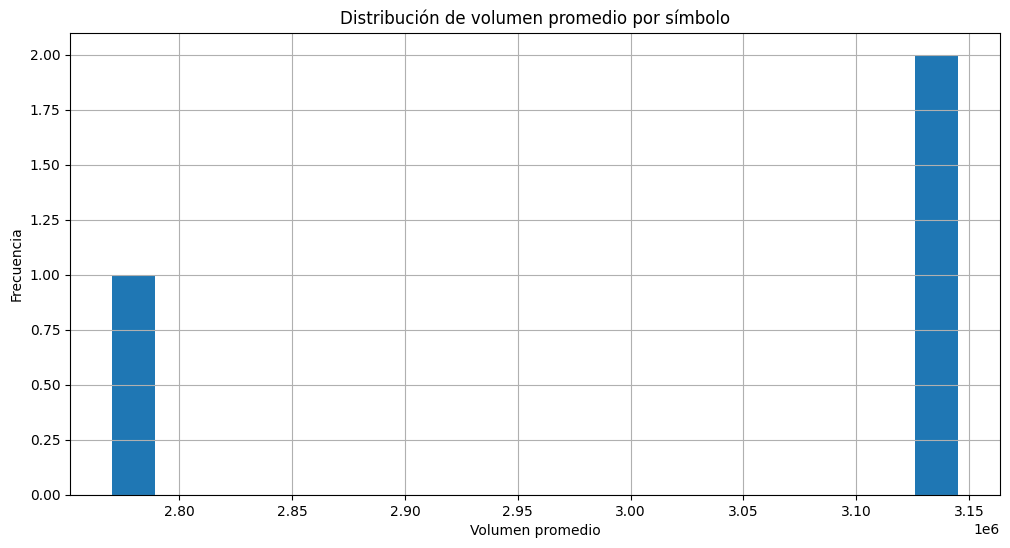

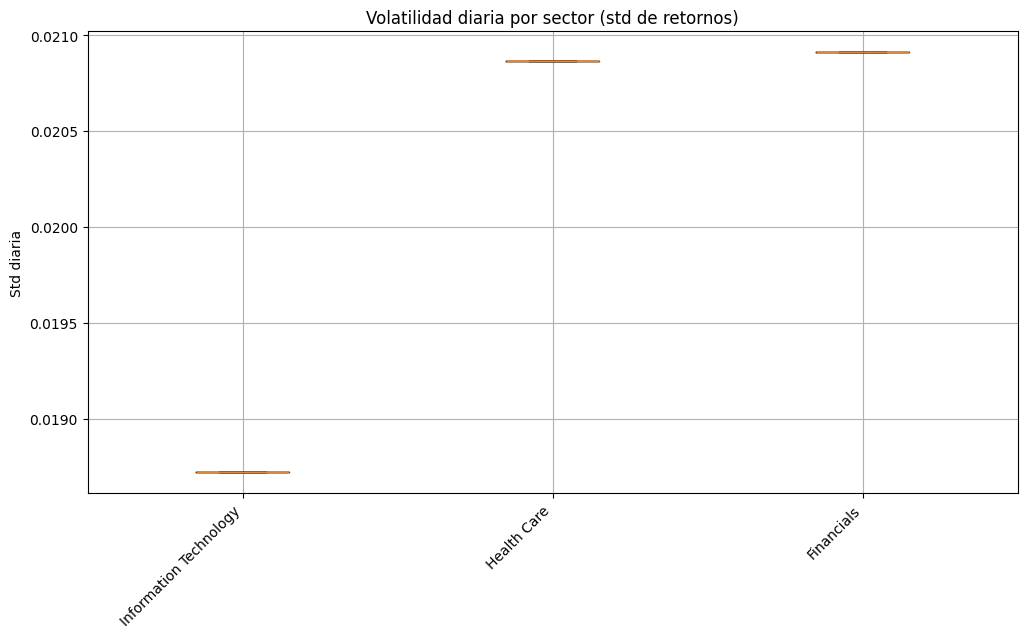

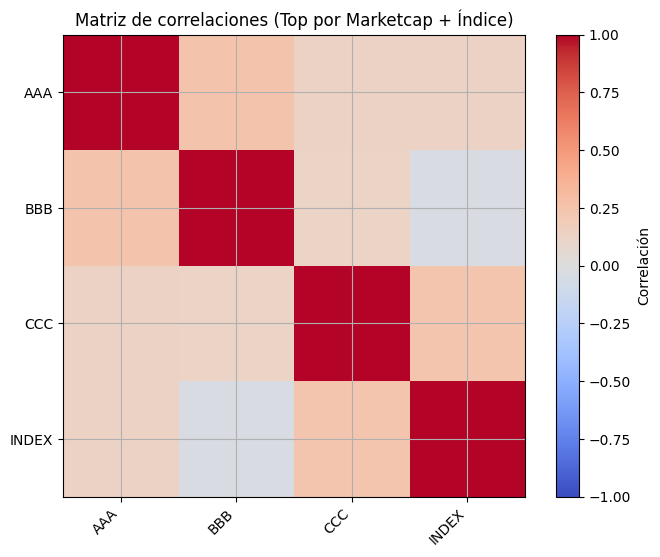

In [11]:
# =============================================================================
# 8. Liquidez, volatilidad y correlaciones
# =============================================================================

vol_avg = stocks.groupby("Symbol")["Volume"].mean().sort_values(ascending=False)

plt.figure()
plt.hist(vol_avg.values, bins=20)
plt.title("Distribución de volumen promedio por símbolo")
plt.xlabel("Volumen promedio")
plt.ylabel("Frecuencia")
plt.show()

vol_diaria = stocks.groupby("Symbol")["ret_d"].std().sort_values(ascending=False)

vol_sec = stocks.groupby(["Symbol","Sector"])["ret_d"].std().reset_index().dropna()
plt.figure()
sectores = vol_sec["Sector"].unique().tolist()
data_box = [vol_sec.loc[vol_sec["Sector"]==s, "ret_d"].values for s in sectores]
plt.boxplot(data_box, tick_labels=sectores, showfliers=True)
plt.title("Volatilidad diaria por sector (std de retornos)")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Std diaria")
plt.show()

N = int(min(10, companies.shape[0]))
topN = companies.sort_values("Marketcap", ascending=False).head(N)["Symbol"].tolist()

ret_mat = stocks.pivot(index="Date", columns="Symbol", values="ret_d")[topN].copy()
ret_mat["INDEX"] = index_df.set_index("Date")["ret"].reindex(ret_mat.index).fillna(0.0)

corr = ret_mat.corr()

plt.figure(figsize=(8,6))
plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.xticks(range(corr.shape[1]), corr.columns, rotation=45, ha="right")
plt.yticks(range(corr.shape[0]), corr.index)
plt.colorbar(label="Correlación")
plt.title("Matriz de correlaciones (Top por Marketcap + Índice)")
plt.show()

# 9. Ventanas móviles y señales simples
- Medias móviles (20/50/200) y detección de cruces (golden/death).  
- Visualización para 1–3 símbolos de ejemplo.  
- Interpretación cualitativa (no predictiva).

In [12]:
# =============================================================================
# 9. Medias móviles y cruces (golden/death)
# =============================================================================

def detectar_cruces(df_sym, w_corta=50, w_larga=200):
    s_c = df_sym[f"sma_{w_corta}"]
    s_l = df_sym[f"sma_{w_larga}"]
    cond_gc = (s_c.shift(1) <= s_l.shift(1)) & (s_c > s_l)
    cond_dc = (s_c.shift(1) >= s_l.shift(1)) & (s_c < s_l)
    fechas_gc = df_sym.loc[cond_gc, "Date"].tolist()
    fechas_dc = df_sym.loc[cond_dc, "Date"].tolist()
    return fechas_gc, fechas_dc

simbolos_plot = stocks["Symbol"].unique().tolist()[:3]

for sym in simbolos_plot:
    d = stocks[stocks["Symbol"]==sym].copy()
    if not set([f"sma_{VENTANAS_MOVILES[0]}", f"sma_{VENTANAS_MOVILES[-1]}"]).issubset(d.columns):
        continue

    # Check if there are any non-null values in the required columns for plotting
    required_cols = ["Adj Close"] + [f"sma_{w}" for w in VENTANAS_MOVILES]
    if d[required_cols].dropna().empty:
        display(Markdown(f"**{sym}: No hay datos válidos para graficar en el rango seleccionado.**"))
        continue

    w_corta = VENTANAS_MOVILES[1] if len(VENTANAS_MOVILES)>1 else 20
    w_larga = VENTANAS_MOVILES[-1]
    fechas_gc, fechas_dc = detectar_cruces(d, w_corta=w_corta, w_larga=w_larga)

    plt.figure()
    plt.plot(d["Date"], d["Adj Close"], label="Adj Close")
    for w in VENTANAS_MOVILES:
        plt.plot(d["Date"], d[f"sma_{w}"], label=f"SMA {w}")
    plt.title(f"{sym}: Precio y medias móviles")
    plt.legend()
    plt.show()

    display(Markdown(f"**{sym} – Golden crosses ({w_corta} vs {w_larga}):** {', '.join([str(f.date()) for f in fechas_gc]) if fechas_gc else 'Ninguno'}"))
    display(Markdown(f"**{sym} – Death  crosses ({w_corta} vs {w_larga}):** {', '.join([str(f.date()) for f in fechas_dc]) if fechas_dc else 'Ninguno'}"))

**AAA: No hay datos válidos para graficar en el rango seleccionado.**

**BBB: No hay datos válidos para graficar en el rango seleccionado.**

**CCC: No hay datos válidos para graficar en el rango seleccionado.**

# 10. Comparativa sectorial profunda
- Retorno acumulado vs índice.  
- Beta simple respecto al índice.  
- Drawdown sectorial.

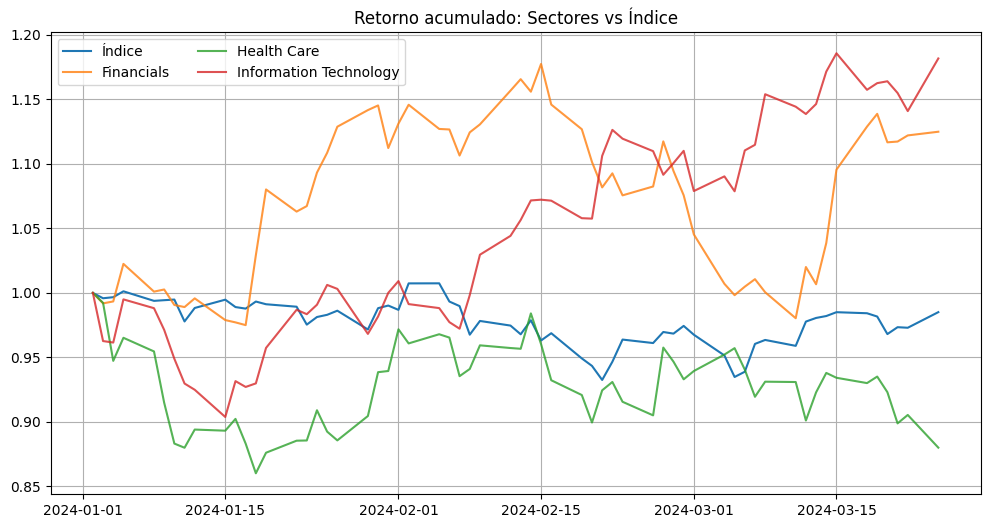

### Betas sectoriales (aprox.) respecto al índice

,Beta
Financials,0.473136
Information Technology,0.227959
Health Care,-0.076719


### Drawdowns sectoriales (máximo)

,Sector,MaxDD,FechaMaxDD
0,Financials,-16.73%,2024-03-11
1,Health Care,-13.98%,2024-01-18
2,Information Technology,-9.62%,2024-01-15


In [13]:
# =============================================================================
# 10. Comparativa sectorial: retorno vs índice, beta y drawdown
# =============================================================================

sector_price_pivot = sector_price.pivot(index="Date", columns="Sector", values="Sector_Price").sort_index()
ret_sector_daily = sector_price_pivot.pct_change().fillna(0.0)

index_ret_series = index_df.set_index("Date")["ret"].reindex(ret_sector_daily.index).fillna(0.0)
beta_sector = {}
for sec in ret_sector_daily.columns:
    x = index_ret_series.values
    y = ret_sector_daily[sec].values
    var_x = np.var(x, ddof=1) if len(x)>1 else np.nan
    cov_xy = np.cov(x, y, ddof=1)[0,1] if len(x)>1 else np.nan
    beta = cov_xy/var_x if var_x and not np.isnan(var_x) else np.nan
    beta_sector[sec] = beta

dd_info = []
for sec in sector_price_pivot.columns:
    eq = (1 + ret_sector_daily[sec]).cumprod()
    dd_s, mdd, f_mdd = calc_drawdown(eq)
    dd_info.append({"Sector": sec, "MaxDD": mdd, "FechaMaxDD": f_mdd})
dd_tab = pd.DataFrame(dd_info).sort_values("MaxDD")

plt.figure()
plt.plot((1+index_ret_series).cumprod(), label="Índice")
for sec in ret_sector_daily.columns:
    plt.plot((1+ret_sector_daily[sec]).cumprod(), label=sec, alpha=0.8)
plt.title("Retorno acumulado: Sectores vs Índice")
plt.legend(loc="best", ncols=2)
plt.show()

display(Markdown("### Betas sectoriales (aprox.) respecto al índice"))
display(pd.Series(beta_sector).to_frame("Beta").sort_values("Beta", ascending=False))

display(Markdown("### Drawdowns sectoriales (máximo)"))
dd_tab["MaxDD"] = dd_tab["MaxDD"].map(lambda x: f"{x:.2%}")
display(dd_tab)

# 11. Sensibilidades y riesgos
- Heatmap de correlaciones entre principales símbolos y el índice.  
- Tabla de drawdowns por símbolo con días de recuperación (si aplica).

In [14]:
# =============================================================================
# 11. Sensibilidades y riesgos: correlaciones y drawdowns por símbolo
# =============================================================================

def tabla_drawdown_por_simbolo(df_prices):
    filas = []
    for sym, g in df_prices.groupby("Symbol"):
        g = g.sort_values("Date")
        eq = (1 + g["ret_d"].fillna(0)).cumprod()
        eq.index = g["Date"]
        dd, mdd, f_mdd = calc_drawdown(eq)
        running_max = eq.cummax()
        if pd.notna(f_mdd):
            hasta = eq.index.get_loc(f_mdd)
            tramo = eq.iloc[:hasta+1]
            pico_mask = tramo == tramo.cummax()
            fechas_pico = tramo.index[pico_mask]
            f_pico = fechas_pico[-1] if len(fechas_pico)>0 else np.nan
        else:
            f_pico = np.nan

        dias_recovery = np.nan
        if pd.notna(f_pico) and pd.notna(f_mdd):
            max_previo = eq.loc[f_pico]
            despues = eq.loc[f_mdd:]
            rec = despues[despues >= max_previo]
            if len(rec)>0:
                dias_recovery = (rec.index[0] - f_mdd).days

        filas.append({
            "Symbol": sym,
            "PeakDate": f_pico.date() if pd.notna(f_pico) else None,
            "TroughDate": f_mdd.date() if pd.notna(f_mdd) else None,
            "MaxDrawdown": mdd,
            "RecoveryDays": dias_recovery
        })
    out = pd.DataFrame(filas)
    out["MaxDrawdown"] = out["MaxDrawdown"].map(lambda x: f"{x:.2%}" if pd.notna(x) else "N/A")
    return out

dd_symbols = tabla_drawdown_por_simbolo(stocks[["Date","Symbol","ret_d"]].copy())
display(Markdown("### Tabla de Drawdowns por símbolo"))
display(dd_symbols.head(20))

### Tabla de Drawdowns por símbolo

,Symbol,PeakDate,TroughDate,MaxDrawdown,RecoveryDays
0,AAA,2024-01-02,2024-01-15,-9.62%,10.0
1,BBB,2024-01-02,2024-01-18,-13.98%,NaN
2,CCC,2024-02-15,2024-03-11,-16.73%,NaN


# 12. Hallazgos de calidad de datos y supuestos
Documentamos nulos/outliers detectados, decisiones de tratamiento y supuestos explícitos.

In [15]:
# =============================================================================
# 12. Hallazgos de calidad y supuestos (resumen)
# =============================================================================

if len(QUALITY_NOTES)==0:
    display(Markdown("> **No se detectaron problemas relevantes de calidad de datos.**"))
else:
    display(Markdown("### Advertencias y hallazgos de calidad"))
    for i, note in enumerate(QUALITY_NOTES, 1):
        display(Markdown(f"- {i}) {note}"))

display(Markdown("""
### Supuestos explícitos
- Se calcula desempeño sectorial promediando retornos diarios de los símbolos de cada sector (sin ponderar).
- Si `Weight` no está disponible, se omite ranking por peso.
- Volatilidades anualizadas por √252 sobre desviaciones de retornos diarios.
- Beta sectorial aproximada por `cov(ret_sector, ret_índice)/var(ret_índice)`.
- Sin ajustes por *survivorship bias*, *splits* u otros eventos corporativos si no están reflejados en `Adj Close`.
- Sin conexión a internet ni uso de APIs: el análisis depende **exclusivamente** de las tres tablas locales.
"""))

### Advertencias y hallazgos de calidad

- 1) ⚠️ Falló la lectura desde Drive: No existe el archivo: /content/drive/MyDrive/BOOTCAMP/sp500_companies.csv. Se cargan datos de ejemplo (mocks) para continuar.

- 2) Detectados 1 outliers en retornos diarios usando IQR. Se recomienda revisión puntual o winsorización si corresponde.


### Supuestos explícitos
- Se calcula desempeño sectorial promediando retornos diarios de los símbolos de cada sector (sin ponderar).
- Si `Weight` no está disponible, se omite ranking por peso.
- Volatilidades anualizadas por √252 sobre desviaciones de retornos diarios.
- Beta sectorial aproximada por `cov(ret_sector, ret_índice)/var(ret_índice)`.
- Sin ajustes por *survivorship bias*, *splits* u otros eventos corporativos si no están reflejados en `Adj Close`.
- Sin conexión a internet ni uso de APIs: el análisis depende **exclusivamente** de las tres tablas locales.


# 13. Conclusiones ejecutivas (para Gerencia)
Resumen de insights y siguientes acciones sugeridas.

In [16]:
# =============================================================================
# 13. Conclusiones ejecutivas (generadas a partir de métricas)
# =============================================================================

lead_sector = (sector_kpi.sort_values("ret_acum", ascending=False).head(3)["Sector"].tolist()
               if sector_kpi.shape[0]>0 else [])
lag_sector  = (sector_kpi.sort_values("ret_acum", ascending=True ).head(3)["Sector"].tolist()
               if sector_kpi.shape[0]>0 else [])

top_g_syms  = []
bot_g_syms  = []
try:
    top_g_syms  = tabla_perf.sort_values("Retorno_total", ascending=False).head(3)["Symbol"].tolist()
    bot_g_syms  = tabla_perf.sort_values("Retorno_total", ascending=True ).head(3)["Symbol"].tolist()
except Exception:
    pass

bullets = f"""
- El índice **S&P 500** mostró un **retorno acumulado** de **{met['Retorno acumulado período'].iloc[0]}** con **volatilidad anualizada** de **{met['Volatilidad anualizada'].iloc[0]}**.
- El **máximo drawdown** registrado fue **{met['Máximo drawdown'].iloc[0]}** (fecha: {met['Fecha max DD'].iloc[0]}).
- Sectores con mejor desempeño reciente: **{', '.join(lead_sector) if lead_sector else 'N/D'}**; sectores rezagados: **{', '.join(lag_sector) if lag_sector else 'N/D'}**.
- Entre las compañías, destacan por retorno: **{', '.join(top_g_syms) if top_g_syms else 'N/D'}**; rezagadas: **{', '.join(bot_g_syms) if bot_g_syms else 'N/D'}**.
- La **correlación** elevada entre líderes sugiere revisar la **diversificación** efectiva al combinar posiciones.
- Señales de **cruces de medias** detectadas en ejemplos ilustran cambios de tendencia, útiles para monitoreo, no como señales predictivas.
- Riesgos: sensibilidad a choques de mercado (betas sectoriales>1) y tiempos de **recuperación** tras drawdowns en ciertos símbolos.
- **Recomendación:** Monitorear (i) ratio retorno/volatilidad por sector, (ii) drawdowns en tiempo real, (iii) volúmenes anómalos y (iv) correlaciones entre posiciones grandes.
- **Siguientes pasos sugeridos** en la Sección 14 para profundizar en valoración y fundamentos.
"""

display(Markdown(bullets))


- El índice **S&P 500** mostró un **retorno acumulado** de **-1.49%** con **volatilidad anualizada** de **16.51%**.
- El **máximo drawdown** registrado fue **-7.43%** (fecha: 2024-02-21).
- Sectores con mejor desempeño reciente: **Information Technology, Financials, Health Care**; sectores rezagados: **Health Care, Financials, Information Technology**.
- Entre las compañías, destacan por retorno: **AAA, CCC, BBB**; rezagadas: **BBB, CCC, AAA**.
- La **correlación** elevada entre líderes sugiere revisar la **diversificación** efectiva al combinar posiciones.
- Señales de **cruces de medias** detectadas en ejemplos ilustran cambios de tendencia, útiles para monitoreo, no como señales predictivas.
- Riesgos: sensibilidad a choques de mercado (betas sectoriales>1) y tiempos de **recuperación** tras drawdowns en ciertos símbolos.
- **Recomendación:** Monitorear (i) ratio retorno/volatilidad por sector, (ii) drawdowns en tiempo real, (iii) volúmenes anómalos y (iv) correlaciones entre posiciones grandes.
- **Siguientes pasos sugeridos** en la Sección 14 para profundizar en valoración y fundamentos.


# 14. Próximos pasos y Anexos
- **Tareas sugeridas:** integrar métricas de valoración (P/E, P/B, EV/EBITDA), resultados trimestrales y guidance.
- **Diccionario de datos:** toda la semántica de columnas proviene de las tres tablas locales.
- **Glosario:** Drawdown, Volatilidad, Beta, Retorno acumulado.

In [17]:
# =============================================================================
# 14. Funciones utilitarias (reutilizables)
# =============================================================================

def retorno_acumulado(serie_ret):
    s = (1 + serie_ret.fillna(0)).cumprod()
    return s.iloc[-1] - 1 if len(s)>0 else np.nan

def volatilidad_anualizada(serie_ret):
    return serie_ret.std() * np.sqrt(252)

def beta_simple(y, x):
    if len(y) < 3 or len(x) < 3:
        return np.nan
    v = np.var(x, ddof=1)
    if v == 0 or np.isnan(v):
        return np.nan
    return np.cov(x, y, ddof=1)[0,1] / v

display(Markdown("> **Cuaderno ejecutado con éxito.** Ajusta los parámetros en la Sección 1 y vuelve a ejecutar para explorar escenarios."))

> **Cuaderno ejecutado con éxito.** Ajusta los parámetros en la Sección 1 y vuelve a ejecutar para explorar escenarios.